In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
from itertools import combinations

In [3]:
# Define an RBF (Gaussian) Kernel
def rbf_kernel(X1, X2, length_scale=0.1, sigma_f=1.0):
    """Computes the RBF kernel matrix."""
    sq_dist = cdist(X1, X2, 'sqeuclidean')
    return sigma_f ** 2 * np.exp(-sq_dist / (2 * length_scale ** 2))

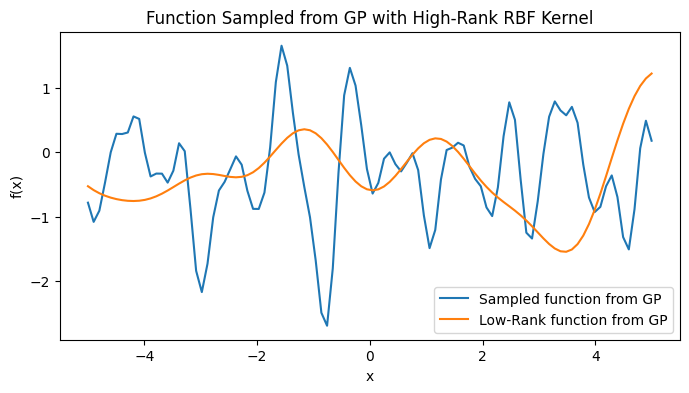

In [4]:
# Generate input points
X = np.linspace(-5, 5, 10**2).reshape(-1, 1)

# Compute kernel matrix (covariance matrix for the GP)
K = rbf_kernel(X, X, length_scale=0.2)
K_low_rank = rbf_kernel(X, X, length_scale=1)

# Sample from a Gaussian Process (mean=0, covariance=K)
f_samples = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K)
f_samples_low_rank = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K_low_rank)

# Plot the sampled function
plt.figure(figsize=(8, 4))
plt.plot(X, f_samples, label="Sampled function from GP")
plt.plot(X, f_samples_low_rank, label="Low-Rank function from GP")
plt.title("Function Sampled from GP with High-Rank RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [2]:
class GaussianUCB:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.sum_rewards = np.zeros(n_arms)
        self.sum_squared_rewards = np.zeros(n_arms)

    def select_arm(self, t):
        ucb_values = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if self.counts[i] == 0:
                return i  # pull each arm once
            mean = self.sum_rewards[i] / self.counts[i]
            variance = (
                self.sum_squared_rewards[i] / self.counts[i]
                - mean ** 2
            )
            variance = max(variance, 1e-6)  # avoid negative due to precision
            bonus = np.sqrt((2 * variance * np.log(t)) / self.counts[i]) + (3 * np.log(t) / self.counts[i])
            ucb_values[i] = mean + bonus
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.sum_rewards[arm] += reward
        self.sum_squared_rewards[arm] += reward ** 2

In [3]:
class GaussianTS:
    def __init__(self, n_arms, known_variance=1.0):
        self.n_arms = n_arms
        self.prior_mean = np.zeros(n_arms)
        self.prior_precision = np.ones(n_arms) * 1e-6  # Start with vague prior
        self.known_variance = known_variance

    def select_arm(self):
        sampled_means = np.random.normal(
            self.prior_mean,
            np.sqrt(self.known_variance / self.prior_precision)
        )
        return np.argmax(sampled_means)

    def update(self, arm, reward):
        self.prior_precision[arm] += 1
        self.prior_mean[arm] += (reward - self.prior_mean[arm]) / self.prior_precision[arm]

In [10]:
class GPfunctions:
    def __init__(self, K, length_scale=None, IfStationary=True):
        self.K=K
        self.num_points= 10 #number of actions
        actionspace =  np.linspace(-1,1,self.num_points) #.reshape(-1, 1) # grid points
        self.actionspace = np.sort(actionspace,axis=0)
        self.length_scale=length_scale
        # Compute covariance matrix
        if IfStationary == True:
            self.kernel = self.rbf_kernel()
        else:
            self.kernel = self.gibbs_kernel()
        self.subset = self.algorithm()
        self.geneate_combinations()
    
    def geneate_combinations(self):
        # Generate all K-action combinations
        all_combinations = list(combinations(range(self.num_points), self.K))
        # Create both dictionaries
        self.combination_index = {comb: idx for idx, comb in enumerate(all_combinations)}
        self.index_combination = {idx: comb for idx, comb in enumerate(all_combinations)}
        # # Example usage:
        # example_comb = (0, 1, 2, 3, 4)
        # example_idx = 1234
        
    # Stationary Gaussian Kernel
    def rbf_kernel(self):
        """Computes the RBF kernel matrix."""
        actionset=self.actionspace.reshape((-1,1))
        sq_dist = cdist(actionset,actionset, 'sqeuclidean')
        return np.exp(-sq_dist / (2 * self.length_scale ** 2))
    
    # Non-stationary Gibbs Kernel
    def gibbs_kernel(self):
        """Computes the Gibbs kernel matrix."""
        K = np.zeros((self.num_points,self.num_points))
        # Compute the kernel matrix
        for i in range(self.num_points):
            for j in range(self.num_points):
                K[i,j] = self.gibbs_kernel_fun(self.actionspace[i],self.actionspace[j])
        return K

    # Define an input-dependent length scale function l(x)
    def length_scale_fun(self, x):
        return 0.1 + 0.9* np.exp(-(x/self.length_scale)**2)  # Short length scale near 0, longer away

    # Define the 1D Gibbs kernel function
    def gibbs_kernel_fun(self, x, x_prime):
        l_x = self.length_scale_fun(x)
        l_xp = self.length_scale_fun(x_prime)
        numerator = 2 * l_x * l_xp
        denominator = l_x**2 + l_xp**2
        prefactor = np.sqrt(numerator / denominator)
        exponent = - (x - x_prime)**2 / denominator
        return prefactor * np.exp(exponent)

    def samples(self,size):
        # Sample multiple functions from the GP
        return np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel,size=size)

    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = self.samples(size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        subset = np.unique(max_indices)
        while len(subset)< self.K: # add more items until K distinct actions are found
            f_samples = self.samples(size=self.K-len(subset))
            max_indices = np.argmax(f_samples, axis=1)
            subset = np.append(subset,np.unique(max_indices))
        # print("Unique actions:", subset)
        return subset
    
    def test(self,subset):
        num_batches = 10**5  # Number of function samples for testing
        # Sample multiple functions from the GP
        f_samples = self.samples(size=num_batches) # np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        return np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,subset], axis=1))

    def run_ucb(self, time_steps=1000):
        bandit = GaussianUCB(len(self.combination_index))
        rewards = []
        for t in range(1, time_steps + 1):
            arm = bandit.select_arm(t)
            selected_actions = list(self.index_combination[arm])
            # print(selected_actions)
            f_samples = self.samples(size=1).reshape(-1)
            reward = np.max(f_samples)-np.max(f_samples[selected_actions])
            bandit.update(arm, reward)
            rewards.append(reward)

        # print("Estimated values:", bandit.values)
        return selected_actions

    def run_ts(self, time_steps=1000):
        bandit = GaussianTS(len(self.combination_index), known_variance=1)
        rewards = []
        for _ in range(time_steps):
            arm = bandit.select_arm()
            selected_actions = list(self.index_combination[arm])
            # print(selected_actions)
            f_samples = self.samples(size=1).reshape(-1)
            reward = np.max(f_samples[selected_actions]) #np.max(f_samples)-
            bandit.update(arm, reward)
            rewards.append(reward)

        # print("Estimated means:", bandit.prior_mean)
        return selected_actions

In [5]:
import math

In [9]:
result = math.comb(20,4)
print(result)  # Output: 10

4845


In [11]:
IfStationary=True
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[0.5,1,2,3,4,5,6] #0.1,0.5,1,

for K in [3,4,5]:
    for length_scale in length_range:
        for ignore in range(50):
            fun=GPfunctions(K,length_scale=length_scale,IfStationary=IfStationary)
            output=fun.test(fun.subset)
            ucb=fun.test(fun.run_ucb(time_steps=1000))
            ts=fun.test(fun.run_ts(time_steps=1000))
            row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
            row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
            row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
            report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

# report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

In [14]:
report.to_csv('report.csv',index=None)

In [1]:
IfStationary=False
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
length_range=[1,3,5] #0.1,0.5,1,

for K in [3,5]:
    for ignore in range(5):
        for length_scale in length_range:
            fun=GPfunctions(K,length_scale,IfStationary=IfStationary)
            output=fun.test(fun.subset)
            ucb=fun.test(fun.run_ucb(time_steps=500))
            ts=fun.test(fun.run_ts(time_steps=2000))
            row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
            row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
            row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
            report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

# report.to_csv('report_Stationary'+str(IfStationary)+'.csv',index=None)

NameError: name 'pd' is not defined

In [75]:
sum(report['EmpiricialRegret']<=0)

0

In [12]:
report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']

length_scale  K  method 
0.5           3  epsilon    0.117750
                 ts         0.105929
                 ucb        0.114200
              4  epsilon    0.078373
                 ts         0.079604
                              ...   
6.0           4  ts         0.023031
                 ucb        0.013622
              5  epsilon    0.000300
                 ts         0.017181
                 ucb        0.008701
Name: EmpiricialRegret, Length: 63, dtype: float64

**Plots**

In [15]:
report=pd.read_csv('report10.csv')
length_range=[1,2,3,4,5,6]

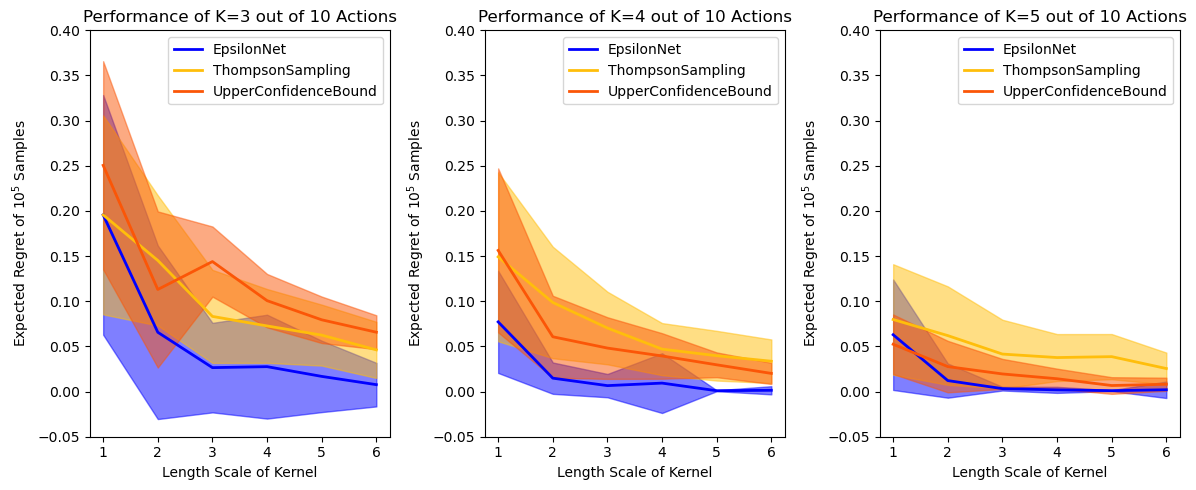

In [16]:
fig, axes = plt.subplots(1,3,figsize=(12, 5))  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [3,4,5]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
for i in range(3):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=2)
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([-0.05,0.4])
    axes[i].set_title("Performance of K={} out of 10 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend()

# Save plot as a PDF without margins
# plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

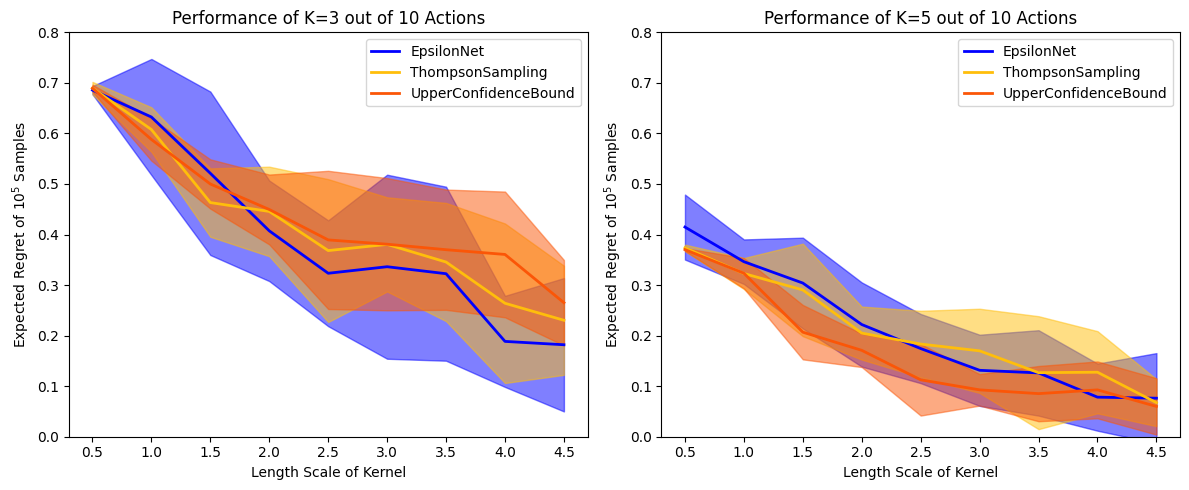

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [3,5]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
# length_range=[0.5,1,1.5,2,2.5]
for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m],linewidth=2)
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([0,0.8])
    axes[i].set_title("Performance of K={} out of 10 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend()

# Save plot as a PDF without margins
# plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

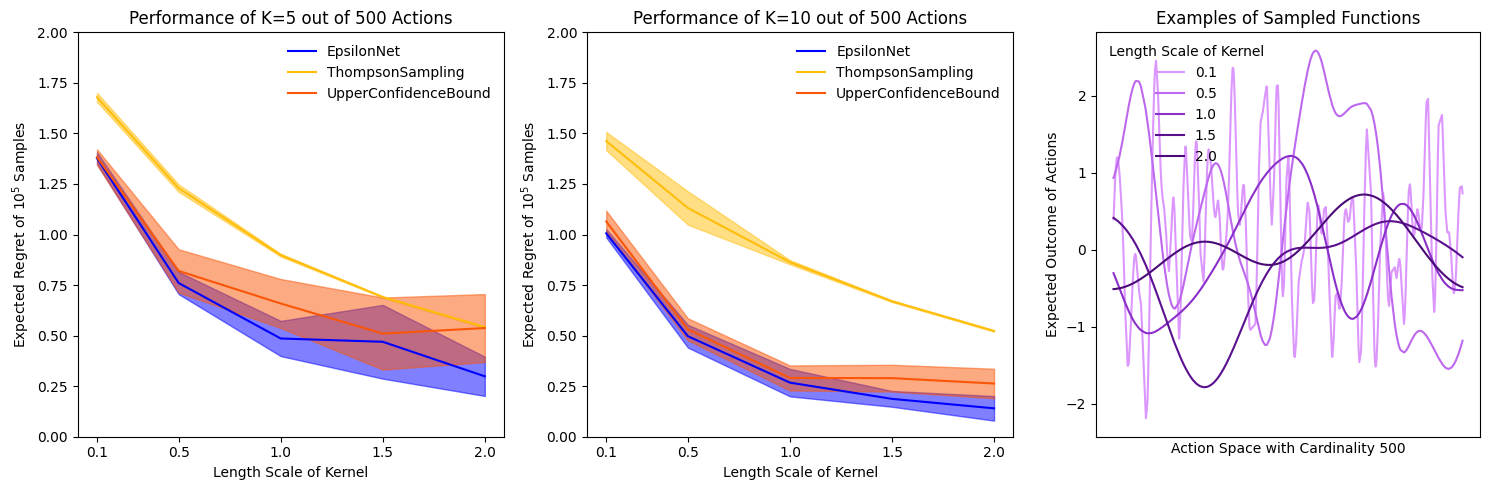

In [68]:
fig, axes = plt.subplots(1,3,figsize=(15, 5), gridspec_kw={'width_ratios': [1,1,0.9]})  # (rows, cols)
# plt.subplots_adjust(wspace=0, hspace=0)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [5,10]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))
colormap_sample = dict(zip(length_range, ['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m])
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([0,2])
    axes[i].set_title("Performance of K={} out of 500 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend(frameon=False)

i=2
for l in length_range:
    fun=GPfunctions(1,l)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap_sample[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',frameon=False)

# Save plot as a PDF without margins
plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

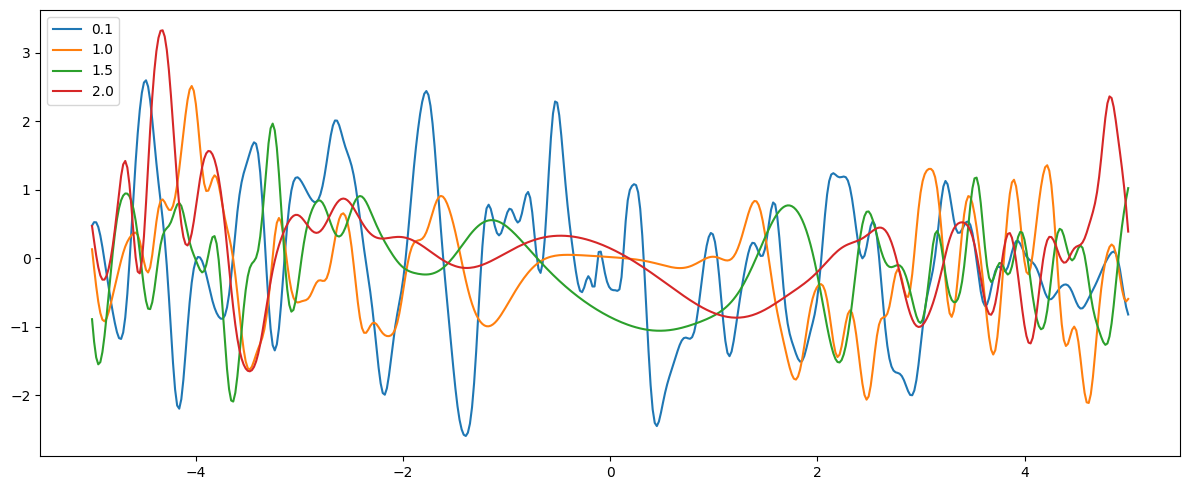

In [93]:
fig, axes = plt.subplots(figsize=(12, 5))  # (rows, cols)

for l in [0.1,1,1.5,2]:
    fun=GPfunctions(1,l,IfStationary=False)
    axes.plot(fun.actionspace,fun.samples(size=1).reshape(-1),label="{:.1f}".format(l))

plt.legend()
# Adjust layout
plt.tight_layout()
plt.show()

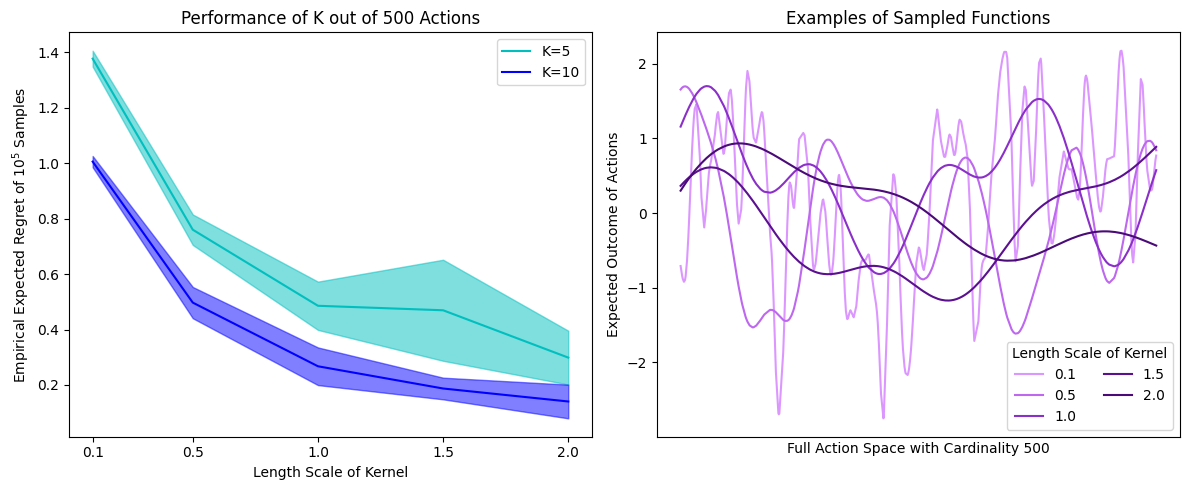

In [32]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
colormap = dict(zip([5,10]+length_range, ['c','b']+['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

i=0
for K in [5,10]:
    dfmean=report_ep.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[i][K] for i in length_range])
    dfstd=report_ep.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
    std=np.array([dfstd[i][K] for i in length_range])
    axes[i].plot(length_range, mean, label="K={}".format(K), color=colormap[K])
    axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[K],alpha=0.5)

# axes[i].set_ylim([0,1.5])
axes[i].set_title("Performance of K out of 500 Actions")
axes[i].set_xlabel("Length Scale of Kernel")
axes[i].set_xticks(length_range)
axes[i].set_ylabel(r"Empirical Expected Regret of $10^5$ Samples")
axes[i].legend()

i=1
for l in length_range:
    fun=GPfunctions(1,l,actionspace=actionspace)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Full Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',ncol=2)

# Save plot as a PDF without margins
# plt.savefig("RKHS.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [337]:
def thompson_sampling_action_selection(alpha, beta, K=5):
    """
    Selects a subset of K actions using Thompson Sampling.
    
    alpha, beta: Parameters of the Beta distribution for each action.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    sampled_values = np.random.beta(alpha, beta)  # Sample from Beta distribution
    selected_actions = np.argsort(sampled_values)[-K:]  # Select top K actions
    return selected_actions

# Example usage
num_actions = 10
alpha = np.ones(num_actions)  # Prior successes (initialize as 1)
beta = np.ones(num_actions)   # Prior failures (initialize as 1)
selected_actions = thompson_sampling_action_selection(alpha, beta, K=5)

print("Selected actions using Thompson Sampling:", selected_actions)

Selected actions using Thompson Sampling: [2 5 6 0 7]


In [338]:
def ucb_action_selection(Q, N, t, c=1.0, K=5):
    """
    Selects a subset of K actions using Upper Confidence Bound (UCB).
    
    Q: Estimated rewards for each action.
    N: Number of times each action has been selected.
    t: Current time step.
    c: Exploration-exploitation trade-off parameter.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    ucb_values = Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5))  # Avoid division by zero
    selected_actions = np.argsort(ucb_values)[-K:]  # Top K actions with highest UCB
    return selected_actions

# Example usage
num_actions = 10
Q = np.random.rand(num_actions)  # Random estimated rewards
N = np.ones(num_actions)  # Initialize with 1 to avoid division by zero
t = 100  # Current time step
selected_actions = ucb_action_selection(Q, N, t, K=5)

print("Selected actions using UCB:", selected_actions)


Selected actions using UCB: [2 8 9 0 1]


In [194]:


dfmean=report.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
mean=np.array([dfmean[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])
dfstd=report.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
std=np.array([dfstd[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])



In [277]:
report.groupby(by=["length_scale",'K']).mean()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.968969
             10.0          0.658666
0.2          5.0           0.969845
             10.0          0.612436
0.5          5.0           0.664523
             10.0          0.370710
1.0          5.0           0.515914
             10.0          0.279531
1.5          5.0           0.404753
             10.0          0.112570
2.0          5.0           0.258277
             10.0          0.106087

In [278]:
report.groupby(by=["length_scale",'K']).std()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.008003
             10.0          0.031927
0.2          5.0           0.055027
             10.0          0.108203
0.5          5.0           0.080587
             10.0          0.053958
1.0          5.0           0.117663
             10.0          0.056348
1.5          5.0           0.069309
             10.0          0.059978
2.0          5.0           0.086438
             10.0          0.048114